Found 435 images belonging to 2 classes.
Found 108 images belonging to 2 classes.
Classes (index -> label): {'injured_animals': 0, 'not_injured_animals': 1}
Train samples: 435
Validation samples: 108
Class weights: {0: 1.0406698564593302, 1: 0.9623893805309734}
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                            

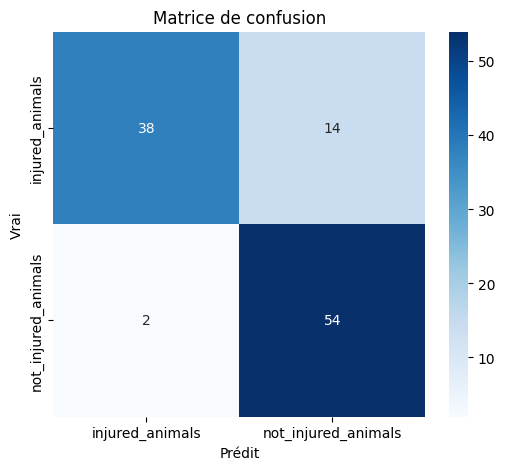

                     precision    recall  f1-score   support

    injured_animals       0.95      0.73      0.83        52
not_injured_animals       0.79      0.96      0.87        56

           accuracy                           0.85       108
          macro avg       0.87      0.85      0.85       108
       weighted avg       0.87      0.85      0.85       108



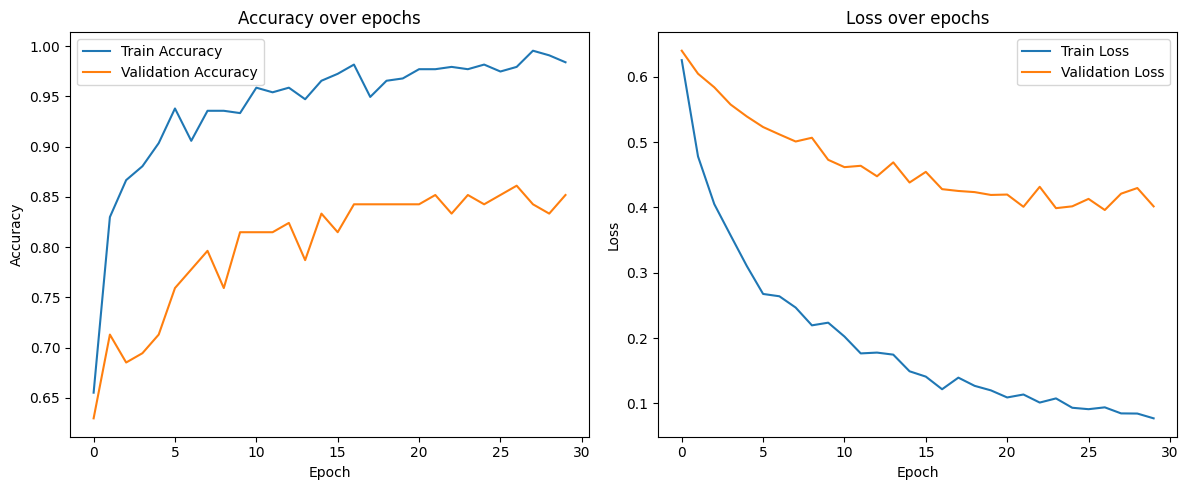

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------- PARAMÈTRES ----------------
dataset_path = '../dataset_corrige_animals/'
img_size = (224, 224)   # MobileNetV2 préfère au moins 224x224
batch_size = 32
epochs = 30

# ------------- DATA AUGMENTATION ------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% pour validation
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# ------------- GENERATEURS ----------------
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

# Afficher nombre images par classe
print("Classes (index -> label):", train_generator.class_indices)
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

# ------------- GESTION DU DÉSÉQUILIBRE ----------------
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# ------------- CRÉATION DU MODÈLE -------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*img_size, 3))
base_model.trainable = False  # on freeze les couches pré-entraînées pour commencer

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ------------- CALLBACKS ------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# ------------- ENTRAÎNEMENT ----------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=callbacks
)

# ------------- ÉVALUATION ----------------
val_generator.reset()
val_preds = model.predict(val_generator)
val_preds_classes = (val_preds > 0.5).astype(int).reshape(-1)

# Vraies classes
val_true = val_generator.classes

# Matrice de confusion
cm = confusion_matrix(val_true, val_preds_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de confusion')
plt.show()

# Rapport classification
print(classification_report(val_true, val_preds_classes, target_names=list(train_generator.class_indices.keys())))

# ------------- COURBES LOSS / ACCURACY ---------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
model.save("injured_animal_detection_V7.h5")